# Seldon deployment of income classifier and Alibi anchor explainer

The objective of this tutorial is to build a "loan approval" predictor using the Income classifier dataset to showcase the importance of black-box model explainers, which in this case are built using our open source framework [Alibi](http://github.com/SeldonIO/Alibi). The diagram of this tutorial is as follows:

![deploy-overview](https://github.com//SeldonIO/seldon-core/raw/master/examples/explainers/alibi_anchor_tabular/img/deploy-overview.jpg)

In this tutorial we will follow the following steps:

1) Train a model to predict loan approvals

2) Containerise and deploy your model

3) Create an explainer to understand predictions

4) Containerise and deploy your explainer

5) Test the predictions as well as explanations

## Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* ksonnet v0.13.1+
* kfctl 0.5.1 - Please use this exact version as there are major changes every few months
* Python 3.6+
* Python DEV requirements (we'll install them below)

You can follow this [notebook](../../../notebooks/seldon_core_setup.ipynb) to setup your cluster.

Let's get started! 🚀🔥 


### Install python dependencies

In [1]:
!cat requirements-dev.txt

xai==0.0.5
seldon_core==0.5.1
alibi==0.3.2
dill==0.3.1
scikit-learn==0.20.1


In [2]:
!pip install -r requirements-dev.txt

Processing /home/rskolasinski/.cache/pip/wheels/b6/26/8f/152327a2b78a0c2c3166e5d20d331bd4fb1272e810836fed76/dill-0.3.1.dev0-cp37-none-any.whl
  Found existing installation: dill 0.3.1.dev0
    Uninstalling dill-0.3.1.dev0:
      Successfully uninstalled dill-0.3.1.dev0
  Rolling back uninstall of dill
  Moving to /home/rskolasinski/.local/bin/get_objgraph
   from /tmp/pip-uninstall-d3876fu7/get_objgraph
  Moving to /home/rskolasinski/.local/bin/undill
   from /tmp/pip-uninstall-d3876fu7/undill
  Moving to /home/rskolasinski/.local/lib/python3.7/site-packages/dill-0.3.1.dev0.dist-info/
   from /home/rskolasinski/.local/lib/python3.7/site-packages/~ill-0.3.1.dev0.dist-info
  Moving to /home/rskolasinski/.local/lib/python3.7/site-packages/dill/
   from /home/rskolasinski/.local/lib/python3.7/site-packages/~ill
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.7/dist-packages/dill-0.3.1.dev0.dist-info'
Consider using the `--

## Setup Seldon Core

Use the setup notebook to [Setup Cluster](../../seldon_core_setup.ipynb#Setup-Cluster) with [Ambassador Ingress](../../seldon_core_setup.ipynb#Ambassador) and [Install Seldon Core](../../seldon_core_setup.ipynb#Install-Seldon-Core). Instructions [also online](./seldon_core_setup.html).

## 1) Train a model to predict loan approvals 

In [3]:
import alibi
import numpy as np

adult = alibi.datasets.fetch_adult()

data = adult.data
labels = adult.target
feature_names = adult.feature_names
category_map = adult.category_map

# define train and test set
np.random.seed(0)
data_perm = np.random.permutation(np.c_[data, labels])
data = data_perm[:, :-1]
labels = data_perm[:, -1]

idx = 30000
X_train, y_train = data[:idx, :], labels[:idx]
X_test, y_test = data[idx + 1:, :], labels[idx + 1:]

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# feature transformation pipeline
ordinal_features = [x for x in range(len(feature_names)) if x not in list(category_map.keys())]
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])

categorical_features = list(category_map.keys())
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', ordinal_transformer, ordinal_features),
                                               ('cat', categorical_transformer, categorical_features)])

In [5]:
preprocessor.fit(data)

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), [0, 8, 9, 10]), ('cat', Pipeline(memory=None,
     steps=[(...oat64'>, handle_unknown='ignore',
       n_values=None, sparse=True))]), [1, 2, 3, 4, 5, 6, 7, 11])])

In [6]:
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)
clf = RandomForestClassifier(n_estimators=50)
clf.fit(preprocessor.transform(X_train), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

,target
precision,0.708042
recall,0.661765
specificity,0.914271
accuracy,0.853906
auc,0.788018
f1,0.684122


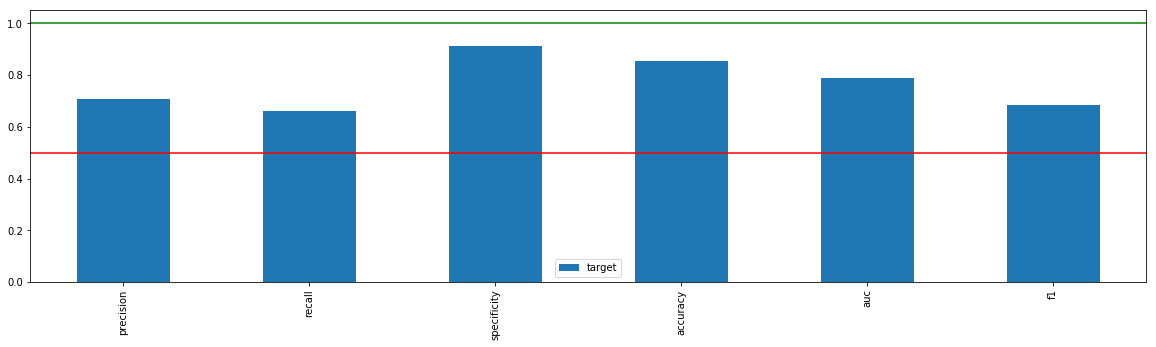

In [7]:
import xai
pred = clf.predict(preprocessor.transform(X_test))
xai.metrics_plot(y_test, pred)

## 2) Containerise and deploy your model

The steps to cotainerise a model with Seldon are always consistent, and require the following steps:

1) Save the model artefacts in the model folder

2) Write a wrapper with a `predict` function

3) Add the python requirements

4) Add the Source2Image configuration so the script knows which Model.py file to use

5) Run the s2i command to build the image

6) Deploy your image with a Seldon Graph Definition

### Once you've deployed it, you are able to test it with Curl or with our Python SeldonClient

Let's start containerising it - we'll be using the following folder for this:

In [8]:
!mkdir -p pipeline/pipeline_steps/loanclassifier

### 2.1 - Save the trained model in the folder 

In [9]:
import dill

with open("pipeline/pipeline_steps/loanclassifier/preprocessor.dill", "wb") as prep_f:
    dill.dump(preprocessor, prep_f)
    
with open("pipeline/pipeline_steps/loanclassifier/model.dill", "wb") as model_f:
    dill.dump(clf, model_f)

### 2.2 - Write a python wrapper for the loan approval model

In [10]:
%%writefile pipeline/pipeline_steps/loanclassifier/Model.py
import dill

class Model:
    def __init__(self, *args, **kwargs):
        
        with open("preprocessor.dill", "rb") as prep_f:
            self.preprocessor = dill.load(prep_f)
        with open("model.dill", "rb") as model_f:
            self.clf = dill.load(model_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        X_prep = self.preprocessor.transform(X)
        proba = self.clf.predict_proba(X_prep)
        print("Predicted: " + str(proba))
        return proba

Overwriting pipeline/pipeline_steps/loanclassifier/Model.py


### 2.3 - Add the python requirements for the image

In [11]:
%%writefile pipeline/pipeline_steps/loanclassifier/requirements.txt
scikit-learn==0.20.1
dill==0.3.1
scikit-image==0.15.0
scikit-learn==0.20.1
scipy==1.1.0
numpy==1.15.4

Overwriting pipeline/pipeline_steps/loanclassifier/requirements.txt


### 2.4 - Create the source2image configuration file

In [12]:
!mkdir -p pipeline/pipeline_steps/loanclassifier/.s2i

In [13]:
%%writefile pipeline/pipeline_steps/loanclassifier/.s2i/environment
MODEL_NAME=Model
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting pipeline/pipeline_steps/loanclassifier/.s2i/environment


### 2.5 - Now we can build the image

In [14]:
!s2i build pipeline/pipeline_steps/loanclassifier seldonio/seldon-core-s2i-python37:0.18 loanclassifier:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/b6/26/8f/152327a2b78a0c2c3166e5d20d331bd4fb1272e810836fed76
Successfully built dill
Found existing installation: numpy 1.17.4
Uninstalling numpy-1.17.4:
Successfully uninstalled numpy-1.17.4
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


*or* if using Minikube

In [15]:
%%bash
eval $(minikube docker-env)
s2i build pipeline/pipeline_steps/loanclassifier seldonio/seldon-core-s2i-python37:0.18 loanclassifier:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/b6/26/8f/152327a2b78a0c2c3166e5d20d331bd4fb1272e810836fed76
Successfully built dill
Found existing installation: numpy 1.17.4
Uninstalling numpy-1.17.4:
Successfully uninstalled numpy-1.17.4
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


### 2.6 - And deploy it to Kubernetes

In [16]:
%%writefile pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier
spec:
  name: loanclassifier
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier:0.1
          name: model
    graph:
      children: []
      name: model
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier
    replicas: 1

Overwriting pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml


In [18]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier/loanclassifiermodel.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier created


In [31]:
!kubectl get pods

NAME                                                     READY   STATUS    RESTARTS   AGE
ambassador-69b784f9d5-242jz                              1/1     Running   0          99s
ambassador-69b784f9d5-b2655                              1/1     Running   0          99s
ambassador-69b784f9d5-ckrt2                              1/1     Running   0          99s
loanclassifier-loanclassifier-164157f-645c997d57-vqjv4   2/2     Running   0          95s


### Now that it's deployed we can test it with curl
**IMPORTANT:** If you are using minikube (instead of docker desktop) you have to forward the port first with:
```
kubectl port-forward svc/ambassador 8003:80
```

In [32]:
# We'll use the output of the first item:
X_test[:1]

array([[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]])

In [33]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60,  9]]}}" \
    http://localhost:8003/seldon/seldon/loanclassifier/api/v0.1/predictions

{
  "meta": {
    "puid": "sg5tdicpcqtclkohhct1uukc52",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model": "loanclassifier:0.1"
    },
    "metrics": []
  },
  "data": {
    "names": ["t:0", "t:1"],
    "ndarray": [[0.86, 0.14]]
  }
}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   356  100   264  100    92   1571    547 --:--:-- --:--:-- --:--:--  2131


### And we can also test it with the Python SeldonClient

In [34]:
from seldon_core.seldon_client import SeldonClient

batch = X_test[:1]

sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:8003",
    deployment_name="loanclassifier",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest")

client_prediction = sc.predict(data=batch)

print(client_prediction)

Success:True message:
Request:
data {
  ndarray {
    values {
      list_value {
        values {
          number_value: 52.0
        }
        values {
          number_value: 4.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 2.0
        }
        values {
          number_value: 8.0
        }
        values {
          number_value: 4.0
        }
        values {
          number_value: 2.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 60.0
        }
        values {
          number_value: 9.0
        }
      }
    }
  }
}

Response:
meta {
  puid: "v7dkibmv78ajvekrujc4nrlc8m"
  requestPath {
    key: "model"
    value: "loanclassifier:0.1"
  }
}
data {
  names: "t:0"
  names: "t:1"
  ndarray {
    values {
      list_value {
        values {
          nu

## 3) Create an explainer to understand predictions

In [35]:
from alibi.explainers import AnchorTabular

predict_fn = lambda x: clf.predict(preprocessor.transform(x))
explainer = AnchorTabular(predict_fn, feature_names, categorical_names=category_map)

In [36]:
explainer.fit(X_train, disc_perc=[25, 50, 75])

In [37]:
idx = 0
class_names = ['<=50K', '>50K']
predict_fn(X_test[idx].reshape(1, -1))

array([0])

In [38]:
X_train[:1]

array([[27,  4,  4,  2,  1,  4,  4,  0,  0,  0, 44,  9]])

In [39]:
explanation = explainer.explain(X_test[idx], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.96
Coverage: 0.11


### However we need to explain our remotely deployed model in production

For this we can actually create a `predict_remote_fn` that uses our SeldonClient to interact with the production model

In [40]:
from seldon_core.utils import get_data_from_proto

def predict_remote_fn(X):
    from seldon_core.seldon_client import SeldonClient
    from seldon_core.utils import get_data_from_proto
    
    kwargs = {
        "gateway": "ambassador", 
        "deployment_name": "loanclassifier",
        "payload_type": "ndarray",
        "namespace": "seldon",
        "transport": "rest"
    }
    
    try:
        kwargs["gateway_endpoint"] = "localhost:8003"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    except:
        # If we are inside the container, we need to reach the ambassador service directly
        kwargs["gateway_endpoint"] = "ambassador:80"
        sc = SeldonClient(**kwargs)
        prediction = sc.predict(data=X)
    
    y = get_data_from_proto(prediction.response)
    return y

# So the anchor is now connected with the remote model
explainer = AnchorTabular(predict_remote_fn, feature_names, categorical_names=category_map)

#### We train the anchor explainer with the remote model

In [41]:
explainer.fit(X_train, disc_perc=[25, 50, 75])

#### We now can get explanations of the remote model

In [43]:
explanation = explainer.explain(X_test[idx], threshold=0.95)

print('Anchor: %s' % (' AND '.join(explanation['names'])))
print('Precision: %.2f' % explanation['precision'])
print('Coverage: %.2f' % explanation['coverage'])

Anchor: Marital Status = Separated AND Sex = Female
Precision: 0.96
Coverage: 0.11


## 4) Containerise and deploy your explainer

Once again we will follow the same steps to cotainerise a model with Seldon are always consistent, and require the following steps:

1) Save the model artefacts in the model folder

2) Write a wrapper with a `predict` function

3) Add the python requirements

4) Add the Source2Image configuration so the script knows which Model.py file to use

5) Run the s2i command to build the image

6) Deploy your image with a Seldon Graph Definition

### Once you've deployed it, you are able to test it with Curl or with our Python SeldonClient

Let's start containerising it - we'll be using the following folder for this:

In [44]:
!mkdir -p pipeline/pipeline_steps/loanclassifier-explainer

#### 1) Save the model artefacts in the model folder

In [45]:
import dill

with open("pipeline/pipeline_steps/loanclassifier-explainer/explainer.dill", "wb") as x_f:
    dill.dump(explainer, x_f)

#### 2) Write a wrapper with a `predict` function

In [46]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/Explainer.py
import dill
import json
import numpy as np

class Explainer:
    def __init__(self, *args, **kwargs):
        
        with open("explainer.dill", "rb") as x_f:
            self.explainer = dill.load(x_f)
        
    def predict(self, X, feature_names=[]):
        print("Received: " + str(X))
        explanation = self.explainer.explain(X)
        print("Predicted: " + str(explanation))
        return json.dumps(explanation, cls=NumpyEncoder)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (
        np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/Explainer.py


#### 3) Add the python requirements

In [47]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/requirements.txt
scikit-learn==0.20.1
dill==0.3.1.
alibi==0.3.2
seldon-core==0.5.1

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/requirements.txt


#### 4) Add the Source2Image configuration so the script knows which Model.py file to use

In [48]:
!mkdir pipeline/pipeline_steps/loanclassifier-explainer/.s2i

mkdir: cannot create directory ‘pipeline/pipeline_steps/loanclassifier-explainer/.s2i’: File exists


In [49]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/.s2i/environment
MODEL_NAME=Explainer
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/.s2i/environment


#### 5) Run the s2i command to build the image

In [52]:
!s2i build pipeline/pipeline_steps/loanclassifier-explainer seldonio/seldon-core-s2i-python37:0.18 loanclassifier-explainer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/b6/26/8f/152327a2b78a0c2c3166e5d20d331bd4fb1272e810836fed76
Stored in directory: /root/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Stored in directory: /root/.cache/pip/wheels/a7/15/a0/0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Stored in directory: /root/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built dill opt-einsum termcolor absl-py gast wrapt
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


*or* if using minikube

In [53]:
%%bash
eval $(minikube docker-env)
s2i build pipeline/pipeline_steps/loanclassifier-explainer seldonio/seldon-core-s2i-python37:0.18 loanclassifier-explainer:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Stored in directory: /root/.cache/pip/wheels/b6/26/8f/152327a2b78a0c2c3166e5d20d331bd4fb1272e810836fed76
Stored in directory: /root/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
Stored in directory: /root/.cache/pip/wheels/a7/15/a0/0a0561549ad11cdc1bc8fa1191a353efd30facf6bfb507aefc
Stored in directory: /root/.cache/pip/wheels/d7/de/2e/efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Stored in directory: /root/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built dill termcolor absl-py wrapt opt-einsum gast
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


#### 6) Deploy your image with a Seldon Graph Definition

In [57]:
%%writefile pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml
apiVersion: machinelearning.seldon.io/v1alpha2
kind: SeldonDeployment
metadata:
  labels:
    app: seldon
  name: loanclassifier-explainer
spec:
  name: loanclassifier-explainer
  predictors:
  - componentSpecs:
    - spec:
        containers:
        - image: loanclassifier-explainer:0.1
          name: model-explainer
    graph:
      children: []
      name: model-explainer
      type: MODEL
      endpoint:
        type: REST
    name: loanclassifier-explainer
    replicas: 1

Overwriting pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml


In [58]:
!kubectl apply -f pipeline/pipeline_steps/loanclassifier-explainer/loanclassifiermodel-explainer.yaml

seldondeployment.machinelearning.seldon.io/loanclassifier-explainer configured


In [60]:
!kubectl get pods

NAME                                                              READY   STATUS    RESTARTS   AGE
ambassador-69b784f9d5-242jz                                       1/1     Running   0          9m7s
ambassador-69b784f9d5-b2655                                       1/1     Running   0          9m7s
ambassador-69b784f9d5-ckrt2                                       1/1     Running   0          9m7s
loanclassifier-explainer-loanclassifier-explainer-8444816-fvb8r   2/2     Running   0          33s
loanclassifier-loanclassifier-164157f-645c997d57-vqjv4            2/2     Running   0          9m3s


### Now that it's deployed we can query it
**IMPORTANT:** If you are using minikube (instead of docker desktop) you have to forward the port first with:
```
kubectl port-forward svc/ambassador 8003:80
```

#### First we can try Curl

In [61]:
%%bash
curl -X POST -H 'Content-Type: application/json' \
    -d "{'data': {'names': ['text'], 'ndarray': [[52,  4,  0,  2,  8,  4,  2,  0,  0,  0, 60, 9]] }}" \
    http://localhost:8003/seldon/seldon/loanclassifier-explainer/api/v0.1/predictions

{
  "meta": {
    "puid": "v8jc8np25vg8e0olfg3k5nfee4",
    "tags": {
    },
    "routing": {
    },
    "requestPath": {
      "model-explainer": "loanclassifier-explainer:0.1"
    },
    "metrics": []
  },
  "strData": "{\"names\": [\"Marital Status \u003d Separated\", \"Sex \u003d Female\"], \"precision\": 0.96, \"coverage\": 0.1042, \"raw\": {\"feature\": [3, 7], \"mean\": [0.8784933171324423, 0.96], \"precision\": [0.8784933171324423, 0.96], \"coverage\": [0.1753, 0.1042], \"examples\": [{\"covered\": [[67, 0, 4, 2, 0, 0, 4, 1, 3818, 0, 11, 9], [31, 4, 0, 2, 5, 0, 4, 1, 0, 0, 45, 9], [28, 4, 4, 2, 6, 1, 4, 1, 0, 0, 50, 9], [39, 6, 3, 2, 7, 1, 4, 0, 0, 1721, 15, 9], [25, 4, 1, 2, 1, 1, 4, 1, 0, 0, 40, 9], [50, 0, 5, 2, 0, 0, 4, 1, 0, 0, 60, 9], [34, 7, 4, 2, 2, 1, 2, 1, 0, 0, 40, 9], [20, 4, 4, 2, 7, 3, 4, 0, 0, 0, 32, 9], [36, 4, 5, 2, 5, 0, 4, 1, 0, 1977, 50, 9], [51, 7, 2, 2, 8, 0, 4, 1, 7298, 0, 40, 9]], \"covered_true\": [[25, 4, 1, 2, 1, 1, 4, 1, 0, 0, 30, 9], [34, 4, 3, 2, 7

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3513  100  3421  100    92   1983     53  0:00:01  0:00:01 --:--:--  2035


## 5) Test production predictions and explanations

We create a seldon client to send requests to the deployed model as well as the explainer. Here is the diagram of the deployed models:

![](img/deploy-overview.jpg)


In [62]:
sc = SeldonClient(
    gateway="ambassador", 
    gateway_endpoint="localhost:8003",
    payload_type="ndarray",
    namespace="seldon",
    transport="rest")

### Let's have a look at the datapoint we'll use for this prediction

In [63]:
to_explain = X_test[:1]
print(to_explain)

[[52  4  0  2  8  4  2  0  0  0 60  9]]


### We get the prediction from the model in production

In [64]:
resp = sc.predict(data=to_explain, deployment_name="loanclassifier").response
pred = get_data_from_proto(resp)
print('Predicted Label: %s' % ("POSITIVE" if pred[0][0] < 0.5 else "NEGATIVE"))
print('Predicted Probabilities: %s' % pred[0])

Predicted Label: NEGATIVE
Predicted Probabilities: [0.86 0.14]


### By checking our test label, we can see it is indeed correct

In [65]:
print('Actual Label: %s' % ("POSITIVE" if y_test[0] == 1 else "NEGATIVE"))

Actual Label: NEGATIVE


### Now we can use our deployed explainer to explain our prediction

In [66]:
import json
explanation = sc.predict(data=to_explain, deployment_name="loanclassifier-explainer")
exp = json.loads(explanation.response.strData)

print('Anchor: %s' % (' AND '.join(exp['names'])))

Anchor: Marital Status = Separated AND Sex = Female
